 코드는 GitHub aima-python의 코드를 기반으로 일부 수정한 것임.

In [1]:
# 탐색을 통한 문제 해결을 위해 필요한 기반 구조들은 search_common.py에 코드를 옮겨서 저장해뒀음.
from search_common import *
import operator
import random
import numpy as np
import matplotlib.pyplot as plt  # 시각화 모듈
from PIL import Image
import bisect

## 국지적 탐색 알고리즘 구현

### 언덕 등반 탐색

In [2]:
def hill_climbing(problem):
    """언덕 등반 탐색. 최급상승 버전(목표함수를 최대화시키는 문제)"""
    current = Node(problem.initial)
    while True:
        neighbors = expand(problem, current)
        if not neighbors:
            break
        # neighbors들 중에서 가장 큰 값; 동일한 값들 중에서는 랜덤하게 하나 선택.
        neighbor = argmax_random_tie(neighbors, key=lambda node: problem.value(node.state))
        if problem.value(neighbor.state) <= problem.value(current.state):
            break
        current = neighbor
    return current.state


def argmin_random_tie(seq, key=lambda x: x):
    """seq의 원소 중 최소값 리턴. 최소값이 여러개인 경우는 랜덤하게 선택"""
    return min(shuffled(seq), key=key)


def argmax_random_tie(seq, key=lambda x: x):
    """seq의 원소 중 최대값 리턴. 최대값이 여러개인 경우는 랜덤하게 선택"""
    return max(shuffled(seq), key=key)


def shuffled(iterable):
    """iterable 복사본을 만든 후 랜덤 셔플"""
    items = list(iterable)
    random.shuffle(items)
    return items

### Simulated Annealing
schedule 함수로는 $schedule(t) = k \times e^{-\lambda t}$ 사용

In [3]:
def exp_schedule(k=20, lam=0.005, limit=100):
    """simulated annealing용 schedule 함수"""
    return lambda t: (k * np.exp(-lam * t) if t < limit else 0)


def simulated_annealing(problem, schedule=exp_schedule()):
    """simulated annealing"""
    current = Node(problem.initial)
    for t in range(sys.maxsize):
        T = schedule(t)
        if T == 0:
            return current.state
        neighbors = [n for n in expand(problem, current)]
        if len(neighbors) == 0:
            return current.state
        next_choice = random.choice(neighbors)
        delta_e = problem.value(next_choice.state) - problem.value(current.state)
        if delta_e > 0 or probability(np.exp(delta_e / T)):
            current = next_choice

            
def probability(p):
    """p의 확률로 True를 리턴함."""
    return p > random.uniform(0.0, 1.0)

### 유전 알고리즘

In [4]:
def genetic_algorithm(population, fitness_fn, gene_pool=[0, 1], f_thres=None, ngen=1000, pmut=0.1):
    """유전 알고리즘.
        population: 초기 개체군
        fitness_fn: 적응도 함수
        gene_pool: 개체의 유전자들이 가질 수 있는 값들의 리스트
        f_thres: 적응도 임계치. 개체의 적응도가 이 값 이상이 되면 iteration이 멈춤.
        ngen: iteration 수
        pmut: 돌연변이 확률"""
    for i in range(ngen):
        population = [mutate(recombine(*select(2, population, fitness_fn)), gene_pool, pmut)
                      for i in range(len(population))]

        fittest_individual = fitness_threshold(fitness_fn, f_thres, population)
        if fittest_individual:
            return fittest_individual

    return max(population, key=fitness_fn)


def fitness_threshold(fitness_fn, f_thres, population):
    """적응도 함수가 가장 높은 개체 리턴. 그 개체의 적응도가 임계치 미만이면 None 리턴"""
    if not f_thres:
        return None

    fittest_individual = max(population, key=fitness_fn)
    if fitness_fn(fittest_individual) >= f_thres:
        return fittest_individual

    return None

In [5]:
def init_population(pop_number, gene_pool, state_length):
    """개체군 초기화.
    pop_number: 개체군에 포함될 개체 수
    gene_pool: 개체의 유전자들이 가질 수 있는 값들의 리스트
    state_length: 각 개체의 길이"""
    g = len(gene_pool)
    population = []
    for i in range(pop_number):
        new_individual = [gene_pool[random.randrange(0, g)] for j in range(state_length)]
        population.append(new_individual)

    return population


def select(r, population, fitness_fn):
    """선택 연산(selection).
    r: 선택할 개체 수
    population: 개체군
    fitness_fn: 적응도 함수"""
    fitnesses = map(fitness_fn, population)
    sampler = weighted_sampler(population, fitnesses)
    return [sampler() for i in range(r)]


def recombine(x, y):
    """교차 연산(point crossover): 하나의 교차점을 기준으로 결합됨"""
    n = len(x)
    c = random.randrange(0, n)
    return x[:c] + y[c:]


def recombine_uniform(x, y):
    """교차 연산(uniform crossover): 각 유전자 값이 두 부모로부터 랜덤하게 선택되어 결합됨"""
    n = len(x)
    result = [0] * n
    indexes = random.sample(range(n), n)
    for i in range(n):
        ix = indexes[i]
        result[ix] = x[ix] if i < n / 2 else y[ix]

    return ''.join(str(r) for r in result)


def mutate(x, gene_pool, pmut):
    """돌연변이 연산(mutation)"""
    if random.uniform(0, 1) >= pmut:
        return x

    n = len(x)
    g = len(gene_pool)
    c = random.randrange(0, n)
    r = random.randrange(0, g)

    new_gene = gene_pool[r]
    return x[:c] + [new_gene] + x[c + 1:]


def weighted_sampler(seq, weights):
    """weights의 가중치를 사용하여 seq를 랜덤 샘플링하는 함수 리턴."""
    totals = []
    for w in weights:
        totals.append(w + totals[-1] if totals else w)
    return lambda: seq[bisect.bisect(totals, random.uniform(0, totals[-1]))]

## 국지적 탐색을 통한 문제 해결
### 봉우리 찾기 문제(Peak Finding Problem)
결국 극댓값을 찾는 문제. 언덕 등반과 simulated annealing 알고리즘을 적용해보자.

        c
     b  a  d
        e
위와 같이 숫자들이 배치되어 있을 때,
`a>=b and a>=c and a>=d and a>=e` 라면, a는 봉우리(극댓값)임.
이런 봉우리를 찾는 문제. 숫자들의 배치는 다음과 같이 2차원 배열이나 리스트로 표현할 수 있을 것임.

    3  7  2  8
    5  2  9  1
    5  3  3  1

상태는 각 숫자의 좌표를 표현하는 인덱스 튜플로 표현됨. 행 인덱스를 x, 열 인덱스를 y로 하여 (x, y)로 위치를 지정함. 위 예에서 (1, 2) 위치에는 숫자 9가 있음.

행동 또한 (a, b) 형식의 튜플로 표현하는데, 행 인덱스를 a만큼 열 인덱스를 b만큼 이동시키는 행동을 의미함. 따라서 (-1, 0)은 행을 하나 줄이는 행동이므로 Up에 해당함.

In [6]:
# 미리 정의된 행동들
directions4 = [(-1, 0), (0, 1), (1, 0), (0, -1)] # 상우하좌 4 방향 (4방향으로만 행동을 허용하도록 문제를 정의할 경우 사용)
directions8 = directions4 + [(-1, 1), (1, 1), (1, -1), (-1, -1)] # 대각선 4 방향 추가 (대각선 방향 행동도 허용하여 문제 정의할 경우 사용)

class PeakFindingProblem(Problem):
    """봉우리 찾기 문제. 상태는 현재의 위치. 예: (1, 2)"""

    def __init__(self, initial, grid, defined_actions=directions4):
        """grid: 2차원 배열/리스트. grid의 각 상태는 위치 인덱스 튜플 (x, y)로 표현됨.
        defined_actions: 문제에서 허용할 행동 정의(기본값: 4방향 이동 행동)"""
        super().__init__(initial) 
        self.grid = grid
        self.defined_actions = defined_actions
        self.n = len(grid)  # 행 인덱스(x)의 최대값
        assert self.n > 0
        self.m = len(grid[0])  # 열 인덱스(y)의 최대값; 결국 이 그리드의 크기는 n행 m열
        assert self.m > 0

    def actions(self, state):
        """주어진 상태에서 허용되는 행동 리스트"""
        allowed_actions = []
        for action in self.defined_actions:
            next_state = vector_add(state, action)
            if 0 <= next_state[0] <= self.n - 1 and 0 <= next_state[1] <= self.m - 1:
                allowed_actions.append(action)
        return allowed_actions

    def result(self, state, action):
        """행동에 명시된 방향으로 이동"""
        return vector_add(state, action)

    def value(self, state):
        """상태 값: 이 문제에서는 그 위치에 놓인 숫자 값을 리턴함"""
        x, y = state
        assert 0 <= x < self.n
        assert 0 <= y < self.m
        return self.grid[x][y]


def vector_add(a, b):
    """두 벡터의 각 성분별로 덧셈 연산"""
    return tuple(map(operator.add, a, b))

In [7]:
# 숫자들의 배치
grid = [[3, 7, 2, 8], [5, 2, 9, 1], [5, 3, 3, 1]]

    3  7  2  8
    5  2  9  1
    5  3  3  1

초기 상태를 (0, 0) 상태에서 시작하고, 동서남북 4방향으로의 행동만 허용하는 것으로 다음과 같이 문제를 정의하자.

In [8]:
initial = (0, 0)
problem = PeakFindingProblem(initial, grid, directions4)

In [9]:
final = hill_climbing(problem)
print(final, problem.value(final), sep='\t')  # local maximum에서 종료됨

(0, 1)	7


In [10]:
final = simulated_annealing(problem)
print(final, problem.value(final), sep='\t')

(0, 1)	7


In [11]:
# 여러번 반복해서 해를 찾고 그 결과 중 최대값을 리턴하면 최적해일 가능성이 높아질 것임
solutions = {problem.value(simulated_annealing(problem)) for i in range(100)}
print(solutions, max(solutions), sep='\t')

{1, 2, 3, 5, 7, 8, 9}	9


숫자 배치를 바꿔보자.

In [12]:
# 중심에 극대가 놓이는 숫자 배치 생성; 아래 코드 내용은 이해 못해도 됨.
def gaussian_kernel(l=5, sig=1.0):
    ax = np.arange(-l // 2 + 1., l // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx ** 2 + yy ** 2) / (2. * sig ** 2))
    return kernel

In [13]:
grid = gaussian_kernel()
grid

array([[0.01831564, 0.082085  , 0.13533528, 0.082085  , 0.01831564],
       [0.082085  , 0.36787944, 0.60653066, 0.36787944, 0.082085  ],
       [0.13533528, 0.60653066, 1.        , 0.60653066, 0.13533528],
       [0.082085  , 0.36787944, 0.60653066, 0.36787944, 0.082085  ],
       [0.01831564, 0.082085  , 0.13533528, 0.082085  , 0.01831564]])

In [14]:
# grid의 히드맵 생성; 아래 코드 내용은 이해 못해도 됨
def heatmap(grid, cmap='binary', interpolation='nearest'):
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    ax.set_title('Heatmap')
    plt.imshow(grid, cmap=cmap, interpolation=interpolation)
    fig.tight_layout()
    plt.show()

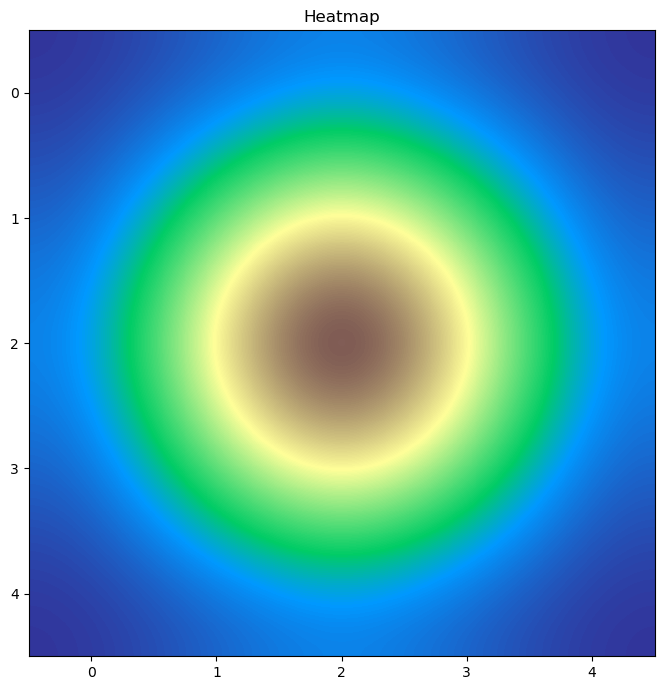

In [15]:
heatmap(grid, cmap='terrain', interpolation='bicubic')

변경된 숫자 배치로 문제를 수정하자. 그리고 허용 가능한 행동을 총 8개(대각선 방향 이동까지 추가)로 정의한다.

In [16]:
problem = PeakFindingProblem(initial, grid, directions8)
directions8

[(-1, 0), (0, 1), (1, 0), (0, -1), (-1, 1), (1, 1), (1, -1), (-1, -1)]

#### 성능 비교

In [17]:
%%time
final = hill_climbing(problem)
print(final, problem.value(final), sep='\t')

(2, 2)	1.0
CPU times: total: 0 ns
Wall time: 0 ns


In [18]:
%%time
final = simulated_annealing(problem)
print(final, problem.value(final), sep='\t')

(1, 4)	0.0820849986238988
CPU times: total: 0 ns
Wall time: 3.27 ms


In [19]:
%%time
solutions = {problem.value(simulated_annealing(problem)) for i in range(100)}
print(solutions, max(solutions), sep='\n')

{0.0820849986238988, 0.36787944117144233, 0.1353352832366127, 0.6065306597126334, 0.01831563888873418, 1.0}
1.0
CPU times: total: 62.5 ms
Wall time: 238 ms


언덕 등반 탐색이 훨씬 속도가 빠름. 그러나...  
숫자 배치를 다음과 같이 바꿔보자.

In [20]:
grid = [[0, 0, 0, 1, 4], 
        [0, 0, 2, 8, 10], 
        [0, 0, 2, 4, 12], 
        [0, 2, 4, 8, 16], 
        [1, 4, 8, 16, 32]]

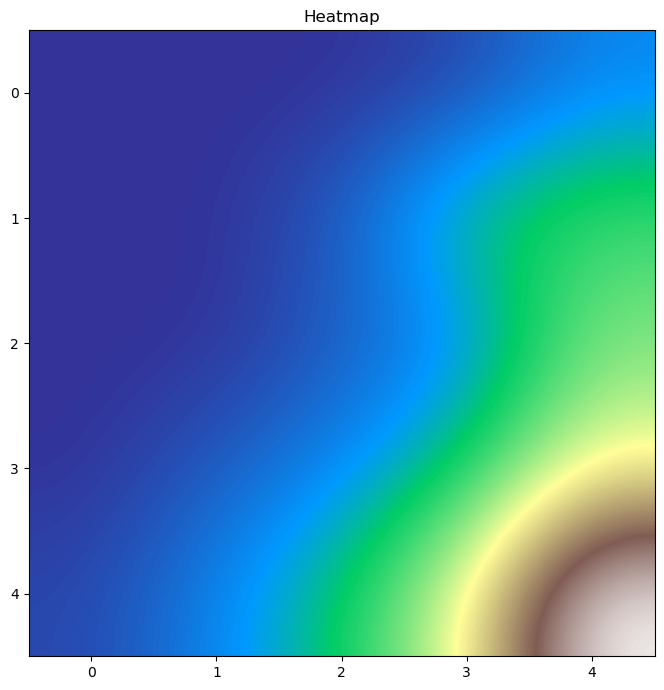

In [21]:
heatmap(grid, cmap='terrain', interpolation='bicubic')

In [22]:
problem = PeakFindingProblem(initial, grid, directions8)

In [23]:
solution = problem.value(hill_climbing(problem))
solution

0

In [24]:
solution = problem.value(simulated_annealing(problem))
solution

8

In [25]:
solutions = {problem.value(simulated_annealing(problem)) for i in range(100)}
max(solutions)

32

동일한 초기 상태에서 시작했지만, 언덕 등반 탐색은 local optimum에서 빠져 나오지 못해 해를 찾지 못했지만 simulated annealing은 해를 찾아낼 수 있었음.

### 8-퀸 문제

8x8 체스판에 8개의 퀸을 서로 공격하지 않는 위치(가로/세로/대각선 방향으로 마주치지 않는 위치)에 배치하는 문제.  
이 문제에서는 상태를 어떻게 표현해야 할까?  
왼쪽부터 각 칼럼에 퀸을 하나씩 배치하도록 하고, 각 칼럼에서 퀸의 위치(행)를 숫자로 표현하면 숫자 8개로 8개의 퀸 배치를 표현할 수 있음.

유전 알고리즘을 적용해보자.
8-퀸 문제를 유전 알고리즘으로 해결하기 위해 각 개체는 8개의 유전자(길이가 8인 스트링)로 구성.
각 유전자는 0~7 숫자(해당 칼럼의 퀸이 몇 번째 줄에 놓여 있는지를 표현함).

In [26]:
# 100개의 초기 개체 생성
population = init_population(100, gene_pool=range(8), state_length=8)
print(population[:5])

[[7, 2, 3, 4, 6, 7, 6, 3], [5, 0, 6, 0, 4, 6, 6, 0], [4, 1, 2, 3, 5, 4, 5, 0], [0, 5, 1, 5, 7, 6, 2, 7], [5, 6, 1, 4, 1, 3, 4, 1]]


In [27]:
# 적응도 함수: 서로 공격하지 않는 위치의 퀸 쌍의 개수. 가능한 최고 점수 = 28.
def fitness(q):
    non_attacking = 0
    for col1 in range(len(q)):
        for col2 in range(col1+1, len(q)):
            row1 = int(q[col1])
            row2 = int(q[col2])
            col_diff = col1 - col2
            row_diff = row1 - row2

            # 같은 행이 아니고 같은 대각선 상에 위치하지 않은지 체크
            if row1 != row2 and col_diff != row_diff and col_diff != -row_diff:
                non_attacking += 1

    return non_attacking

In [28]:
solution = genetic_algorithm(population, fitness_fn=fitness, f_thres=28, gene_pool=range(8), ngen=10)
print(solution, fitness(solution), sep='\n')

[2, 3, 7, 4, 7, 5, 1, 6]
25


In [29]:
solution = genetic_algorithm(population, fitness_fn=fitness, f_thres=28, gene_pool=range(8), ngen=1000)
print(solution, fitness(solution), sep='\n')

[5, 3, 0, 0, 7, 4, 6, 1]
27


In [30]:
# N Queens 문제의 해결책(퀸들의 배치) 시각화 함수; 아래 구현 내용은 이해 못해도 됨.
def plot_NQueens(solution):
    n = len(solution)
    board = np.array([2 * int((i + j) % 2) for j in range(n) for i in range(n)]).reshape((n, n))
    im = Image.open('queen_s.png')
    height = im.size[1]
    im = np.array(im).astype(float) / 255
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    ax.set_title('{} Queens'.format(n))
    plt.imshow(board, cmap='binary', interpolation='nearest')
    # 해결책이 딕셔너리 구조이면
    if isinstance(solution, dict):
        for (k, v) in solution.items():
            newax = fig.add_axes([0.064 + (k * 0.112), 0.062 + ((7 - v) * 0.112), 0.1, 0.1], zorder=1)
            newax.imshow(im)
            newax.axis('off')
    # 해결책이 리스트이면
    elif isinstance(solution, list):
        for (k, v) in enumerate(solution):
            newax = fig.add_axes([0.064 + (k * 0.112), 0.062 + ((7 - v) * 0.112), 0.1, 0.1], zorder=1)
            newax.imshow(im)
            newax.axis('off')
    fig.tight_layout()
    plt.show()

C:\Users\kshan\AppData\Local\Temp\ipykernel_20720\3717777068.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


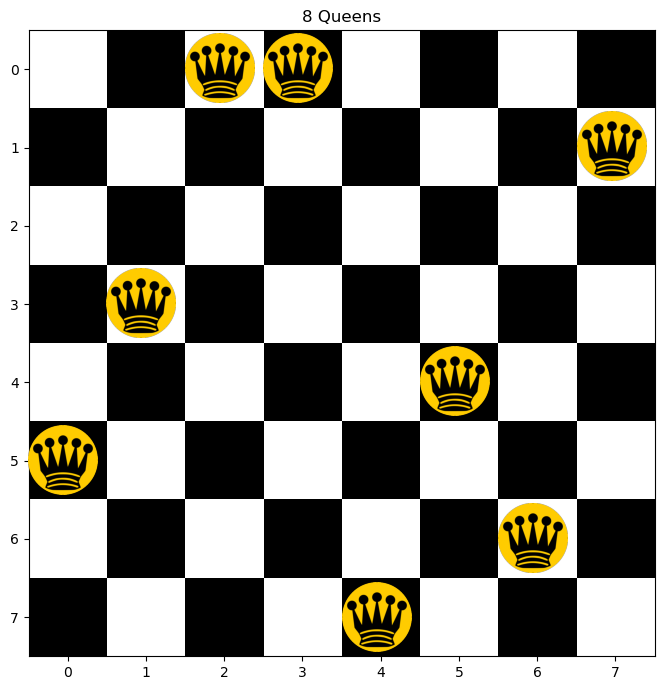

In [31]:
plot_NQueens(solution)